Dataset loading & visualization

Data augmentation & preprocessing

Multiple CNN backbones (MobileNetV2, ResNet50, EfficientNetB0)

Training each model

Evaluation (accuracy, loss, confusion matrix, classification report)

Documentation results table

Dataset Loading & Visualization

Train: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Validation: {'NORMAL': 8, 'PNEUMONIA': 8}
Test: {'NORMAL': 234, 'PNEUMONIA': 390}


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14396\3205151144.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


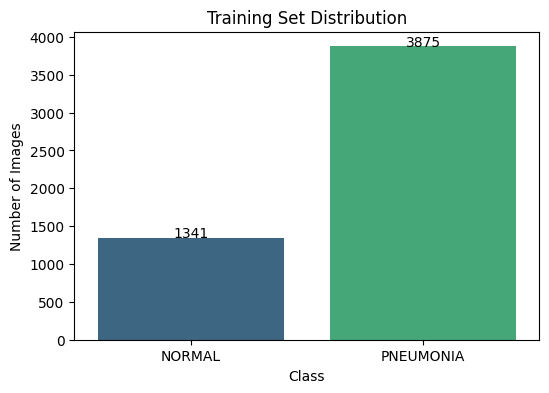

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14396\3205151144.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


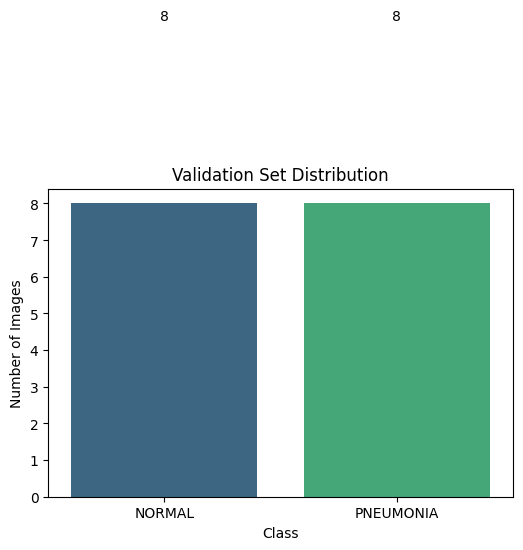

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_14396\3205151144.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


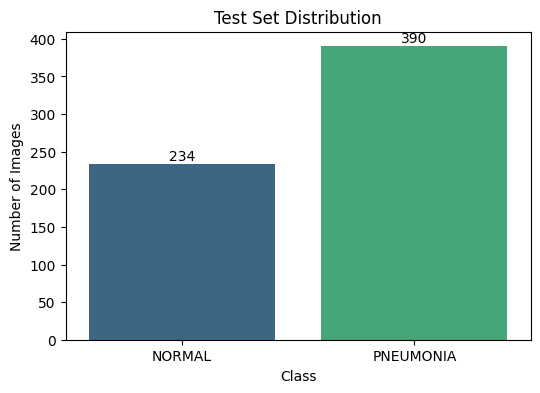

In [1]:
# ==============================================
# 1️⃣ Import Libraries
# ==============================================
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set dataset path
BASE_DIR = "chest_xray"   # 👈 change if needed
train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

# ==============================================
# 2️⃣ Count Images Per Class (for visualization)
# ==============================================
def count_images(directory):
    counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            counts[class_name] = len(os.listdir(class_path))
    return counts

train_counts = count_images(train_dir)
val_counts   = count_images(val_dir)
test_counts  = count_images(test_dir)

print("Train:", train_counts)
print("Validation:", val_counts)
print("Test:", test_counts)

# ==============================================
# 3️⃣ Plot Distribution
# ==============================================
def plot_distribution(counts, title):
    plt.figure(figsize=(6,4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    for i, v in enumerate(counts.values()):
        plt.text(i, v + 5, str(v), ha="center")
    plt.show()

plot_distribution(train_counts, "Training Set Distribution")
plot_distribution(val_counts, "Validation Set Distribution")
plot_distribution(test_counts, "Test Set Distribution")


Data Augmentation & Generators

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


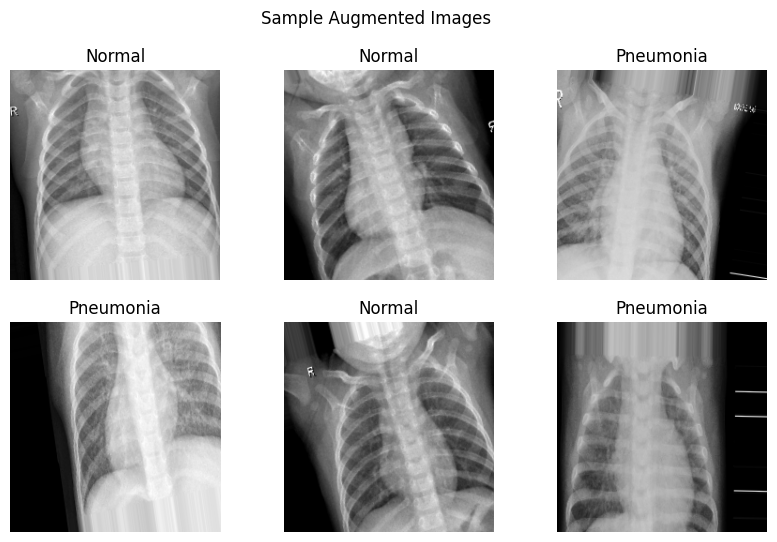

In [2]:
# ==============================================
# 1️⃣ Parameters
# ==============================================
IMG_SIZE = (224, 224)   # works for most CNN backbones
BATCH_SIZE = 32

# ==============================================
# 2️⃣ Data Augmentation for Training
# ==============================================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation & Test data should NOT be augmented
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ==============================================
# 3️⃣ Data Generators
# ==============================================
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

# ==============================================
# 4️⃣ Show Some Augmented Images
# ==============================================
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title("Pneumonia" if sample_labels[i] == 1 else "Normal")
    plt.axis("off")
plt.suptitle("Sample Augmented Images")
plt.show()


Model Training with Different CNN Backbones

In [3]:
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ==================================================
# Helper function to build and train a model
# ==================================================
def build_and_train_model(base_model_class, input_shape=(224, 224, 3), 
                          train_gen=None, val_gen=None, model_name="model"):
    """
    Builds a CNN model with transfer learning, trains it, and saves the best weights.
    """
    # Load pretrained base model
    base_model = base_model_class(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze base model initially

    # Add custom classifier head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    preds = Dense(1, activation="sigmoid")(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=preds)

    # Compile
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

    # Callbacks
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        ModelCheckpoint(f"{model_name}.h5", save_best_only=True, monitor="val_loss")
    ]

    # Train
    history = model.fit(
        train_gen,
        epochs=20,
        validation_data=val_gen,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

# ==================================================
# Train with MobileNetV2
# ==================================================
mobilenet_model, mobilenet_history = build_and_train_model(
    MobileNetV2, input_shape=(224, 224, 3),
    train_gen=train_generator, val_gen=val_generator,
    model_name="mobilenet_model"
)

# ==================================================
# Train with ResNet50
# ==================================================
resnet_model, resnet_history = build_and_train_model(
    ResNet50, input_shape=(224, 224, 3),
    train_gen=train_generator, val_gen=val_generator,
    model_name="resnet_model"
)

# ==================================================
# Train with EfficientNetB0
# ==================================================
efficientnet_model, efficientnet_history = build_and_train_model(
    EfficientNetB0, input_shape=(224, 224, 3),
    train_gen=train_generator, val_gen=val_generator,
    model_name="efficientnet_model"
)


C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5389 - loss: 0.7825

163/163 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.5397 - loss: 0.7815 - val_accuracy: 0.5000 - val_loss: 0.6803
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7724 - loss: 0.4571

163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.7725 - loss: 0.4569 - val_accuracy: 0.6250 - val_loss: 0.5438
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8183 - loss: 0.3832

163/163 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8184 - loss: 0.3831 - val_accuracy: 0.8125 - val_loss: 0.4695
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8632 - loss: 0.3143

163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.8632 - loss: 0.3143 - val_accuracy: 0.8750 - val_loss: 0.4228
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8663 - loss: 0.2987

163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.8663 - loss: 0.2987 - val_accuracy: 0.8750 - val_loss: 0.4015
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8841 - loss: 0.2688

163/163 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8840 - loss: 0.2689 - val_accuracy: 0.8750 - val_loss: 0.3714
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8970 - loss: 0.2529

163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8970 - loss: 0.2529 - val_accuracy: 0.9375 - val_loss: 0.3515
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8970 - loss: 0.2448

163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.8970 - loss: 0.2447 - val_accuracy: 0.9375 - val_loss: 0.3434
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.9035 - loss: 0.2313

163/163 ━━━━━━━━━━━━━━━━━━━━ 160s 979ms/step - accuracy: 0.9035 - loss: 0.2313 - val_accuracy: 0.9375 - val_loss: 0.3344
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8978 - loss: 0.2458

163/163 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.8978 - loss: 0.2457 - val_accuracy: 0.9375 - val_loss: 0.3262
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9014 - loss: 0.2262 - val_accuracy: 0.8750 - val_loss: 0.3280
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9191 - loss: 0.2035

163/163 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9190 - loss: 0.2035 - val_accuracy: 0.9375 - val_loss: 0.3186
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.9121 - loss: 0.2114

163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 989ms/step - accuracy: 0.9121 - loss: 0.2114 - val_accuracy: 0.9375 - val_loss: 0.3168
Epoch 14/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9162 - loss: 0.2016

163/163 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9162 - loss: 0.2016 - val_accuracy: 0.9375 - val_loss: 0.3100
Epoch 15/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9148 - loss: 0.1979

163/163 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9148 - loss: 0.1979 - val_accuracy: 0.9375 - val_loss: 0.3093
Epoch 16/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 940s 6s/step - accuracy: 0.9160 - loss: 0.2045 - val_accuracy: 0.9375 - val_loss: 0.3108
Epoch 17/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.9220 - loss: 0.1983

163/163 ━━━━━━━━━━━━━━━━━━━━ 163s 999ms/step - accuracy: 0.9220 - loss: 0.1983 - val_accuracy: 0.9375 - val_loss: 0.3085
Epoch 18/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.9170 - loss: 0.1921

163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 989ms/step - accuracy: 0.9170 - loss: 0.1921 - val_accuracy: 0.9375 - val_loss: 0.2965
Epoch 19/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 161s 985ms/step - accuracy: 0.9241 - loss: 0.1865 - val_accuracy: 0.9375 - val_loss: 0.3015
Epoch 20/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 975ms/step - accuracy: 0.9130 - loss: 0.2001 - val_accuracy: 0.9375 - val_loss: 0.2970
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 264s 3us/step
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4829 - loss: 0.7867

163/163 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.4836 - loss: 0.7861 - val_accuracy: 0.5000 - val_loss: 0.8320
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.7279 - loss: 0.6126 - val_accuracy: 0.5000 - val_loss: 0.8558
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.7316 - loss: 0.6026 - val_accuracy: 0.5000 - val_loss: 0.8509
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7287 - loss: 0.5994

163/163 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - accuracy: 0.7288 - loss: 0.5994 - val_accuracy: 0.5000 - val_loss: 0.8314
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7343 - loss: 0.5953

163/163 ━━━━━━━━━━━━━━━━━━━━ 904s 6s/step - accuracy: 0.7343 - loss: 0.5952 - val_accuracy: 0.5000 - val_loss: 0.8289
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.7299 - loss: 0.5869 - val_accuracy: 0.5000 - val_loss: 0.8544
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7500 - loss: 0.5694

163/163 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.7499 - loss: 0.5694 - val_accuracy: 0.5000 - val_loss: 0.8170
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7437 - loss: 0.5612

163/163 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.7437 - loss: 0.5612 - val_accuracy: 0.5000 - val_loss: 0.7946
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.7456 - loss: 0.5704 - val_accuracy: 0.5000 - val_loss: 0.8151
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 368s 2s/step - accuracy: 0.7357 - loss: 0.5691 - val_accuracy: 0.5000 - val_loss: 0.8242
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.7490 - loss: 0.5518 - val_accuracy: 0.5000 - val_loss: 0.8124
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7417 - loss: 0.5579 - val_accuracy: 0.5000 - val_loss: 0.7981
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 370s 2s/step - accuracy: 0.7385 - loss: 0.5591 - val_accuracy: 0.5000 - val_loss: 0.8207
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 131s 8us/step
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5590 - loss: 0.6748

163/163 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - accuracy: 0.5597 - loss: 0.6745 - val_accuracy: 0.5000 - val_loss: 0.8283
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.7346 - loss: 0.5817 - val_accuracy: 0.5000 - val_loss: 0.8336
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.7396 - loss: 0.5779 - val_accuracy: 0.5000 - val_loss: 0.8351
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7434 - loss: 0.5722

163/163 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.7434 - loss: 0.5722 - val_accuracy: 0.5000 - val_loss: 0.8273
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7357 - loss: 0.5831 - val_accuracy: 0.5000 - val_loss: 0.8570
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7443 - loss: 0.5701

163/163 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.7443 - loss: 0.5701 - val_accuracy: 0.5000 - val_loss: 0.8224
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.7351 - loss: 0.5840 - val_accuracy: 0.5000 - val_loss: 0.8400
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.7408 - loss: 0.5752 - val_accuracy: 0.5000 - val_loss: 0.8293
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7573 - loss: 0.5585

163/163 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.7573 - loss: 0.5586 - val_accuracy: 0.5000 - val_loss: 0.8201
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7431 - loss: 0.5735 - val_accuracy: 0.5000 - val_loss: 0.8298
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 176s 1s/step - accuracy: 0.7405 - loss: 0.5756 - val_accuracy: 0.5000 - val_loss: 0.8302
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.7439 - loss: 0.5710 - val_accuracy: 0.5000 - val_loss: 0.8488
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.7494 - loss: 0.5648 - val_accuracy: 0.5000 - val_loss: 0.8368
Epoch 14/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.7456 - loss: 0.5697 - val_accuracy: 0.5000 - val_loss: 0.8252


Model Evaluation & Comparison

✅ MobileNetV2 - Test Accuracy: 0.8798, Test Loss: 0.2708

📊 Classification Report for MobileNetV2:
              precision    recall  f1-score   support

      NORMAL       0.86      0.81      0.83       234
   PNEUMONIA       0.89      0.92      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



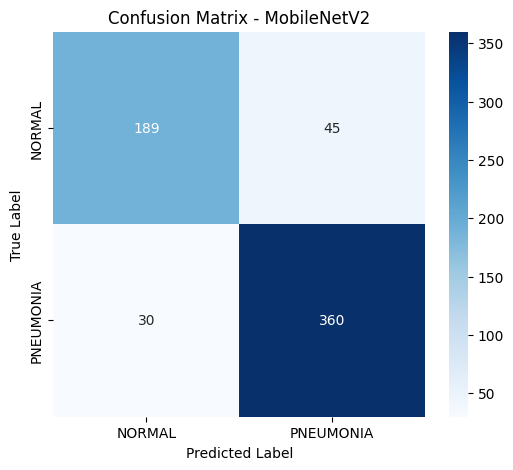

✅ ResNet50 - Test Accuracy: 0.6250, Test Loss: 0.6708

📊 Classification Report for ResNet50:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

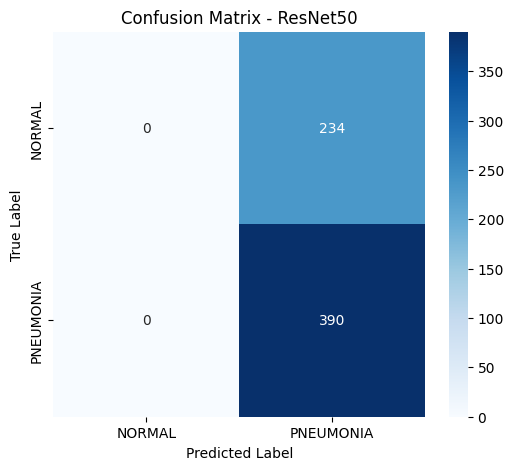

✅ EfficientNetB0 - Test Accuracy: 0.6250, Test Loss: 0.6913

📊 Classification Report for EfficientNetB0:
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\LENOVO\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

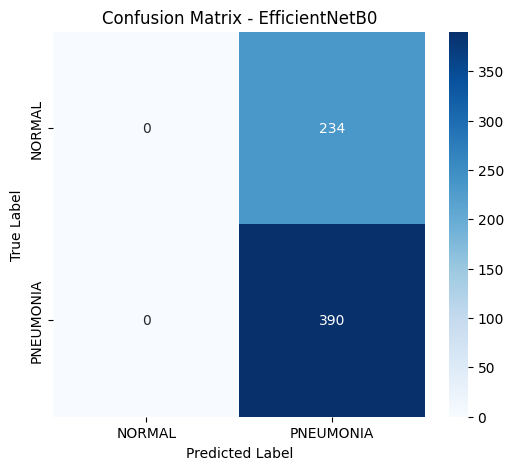

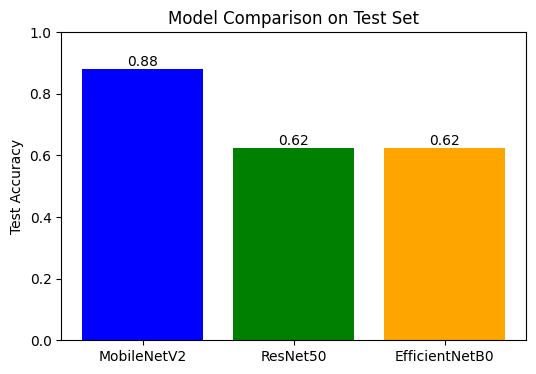

In [4]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# ==================================================
# Helper function for evaluation
# ==================================================
def evaluate_model(model, test_gen, model_name="Model"):
    """
    Evaluates a model on test data, prints accuracy, classification report, 
    and shows confusion matrix.
    """
    # Evaluate on test set
    loss, acc = model.evaluate(test_gen, verbose=0)
    print(f"✅ {model_name} - Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")

    # Predictions
    y_true = test_gen.classes
    y_pred_probs = model.predict(test_gen, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Classification report
    print(f"\n📊 Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=list(test_gen.class_indices.keys()), 
                yticklabels=list(test_gen.class_indices.keys()))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return acc

# ==================================================
# Evaluate all trained models
# ==================================================
mobilenet_acc = evaluate_model(mobilenet_model, test_generator, "MobileNetV2")
resnet_acc = evaluate_model(resnet_model, test_generator, "ResNet50")
efficientnet_acc = evaluate_model(efficientnet_model, test_generator, "EfficientNetB0")

# ==================================================
# Compare Model Accuracies
# ==================================================
model_names = ["MobileNetV2", "ResNet50", "EfficientNetB0"]
accuracies = [mobilenet_acc, resnet_acc, efficientnet_acc]

plt.figure(figsize=(6,4))
plt.bar(model_names, accuracies, color=["blue","green","orange"])
plt.ylabel("Test Accuracy")
plt.title("Model Comparison on Test Set")
for i, acc in enumerate(accuracies):
    plt.text(i, acc+0.01, f"{acc:.2f}", ha="center")
plt.ylim(0,1)
plt.show()
